In [ ]:
#cuda enabled gpu runtime

!pip install ppscore
!pip install catboost
!pip install --upgrade pandas
!pip install --upgrade numpy
!pip install -U scikit-learn==0.21
!pip install scikit-optimize

In [11]:
import numpy as np
import pandas as pd
import ppscore as pps
from mlxtend.feature_selection import ColumnSelector
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import GridSearchCV
from time import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
# from reg_resampler import resampler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, cross_val_score,StratifiedKFold
from imblearn.over_sampling import SMOTE 
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
import csv
import os
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import warnings
# from fastai.structured import add_datepart
from sklearn.pipeline import make_pipeline
from sklearn.metrics import log_loss
from keras.models import Sequential
from google.colab import drive
from sklearn import preprocessing
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.pipeline import Pipeline
import sklearn as sk
from sklearn.metrics import confusion_matrix 
from matplotlib import pyplot
from sklearn.cluster import KMeans
from fancyimpute import KNN
from catboost import CatBoostClassifier, Pool, cv
import warnings
warnings.filterwarnings('ignore')
drive.mount("/GD")

Drive already mounted at /GD; to attempt to forcibly remount, call drive.mount("/GD", force_remount=True).


In [ ]:
def split_numbers_chars(row):
    head = row.rstrip('0123456789')
    tail = row[len(head):]
    return head, tail

#tree models tend to perform well with categories as label encodes or similar instead of one hot encodes as that results in growing of trees in a singular direction
def reverse_one_hot_encode(dataframe, start_loc, end_loc, numeric_column_name):
    dataframe['String_Column'] = (dataframe.iloc[:, start_loc:end_loc] == 1).idxmax(1)
    dataframe['Tuple_Column'] = dataframe['String_Column'].apply(split_numbers_chars)
    dataframe[numeric_column_name] = dataframe['Tuple_Column'].apply(lambda x: x[1]).astype('int64')
    dataframe.drop(columns=['String_Column','Tuple_Column'], inplace=True)

In [62]:

df_train=pd.read_csv("/GD/My Drive/forest/train.csv")
df_test=pd.read_csv("/GD/My Drive/forest/test.csv")

reverse_one_hot_encode(df_train,14,54,'soil_type')
reverse_one_hot_encode(df_train,10,14,'wilderness')
reverse_one_hot_encode(df_test,14,54,'soil_type')
reverse_one_hot_encode(df_test,10,14,'wilderness')


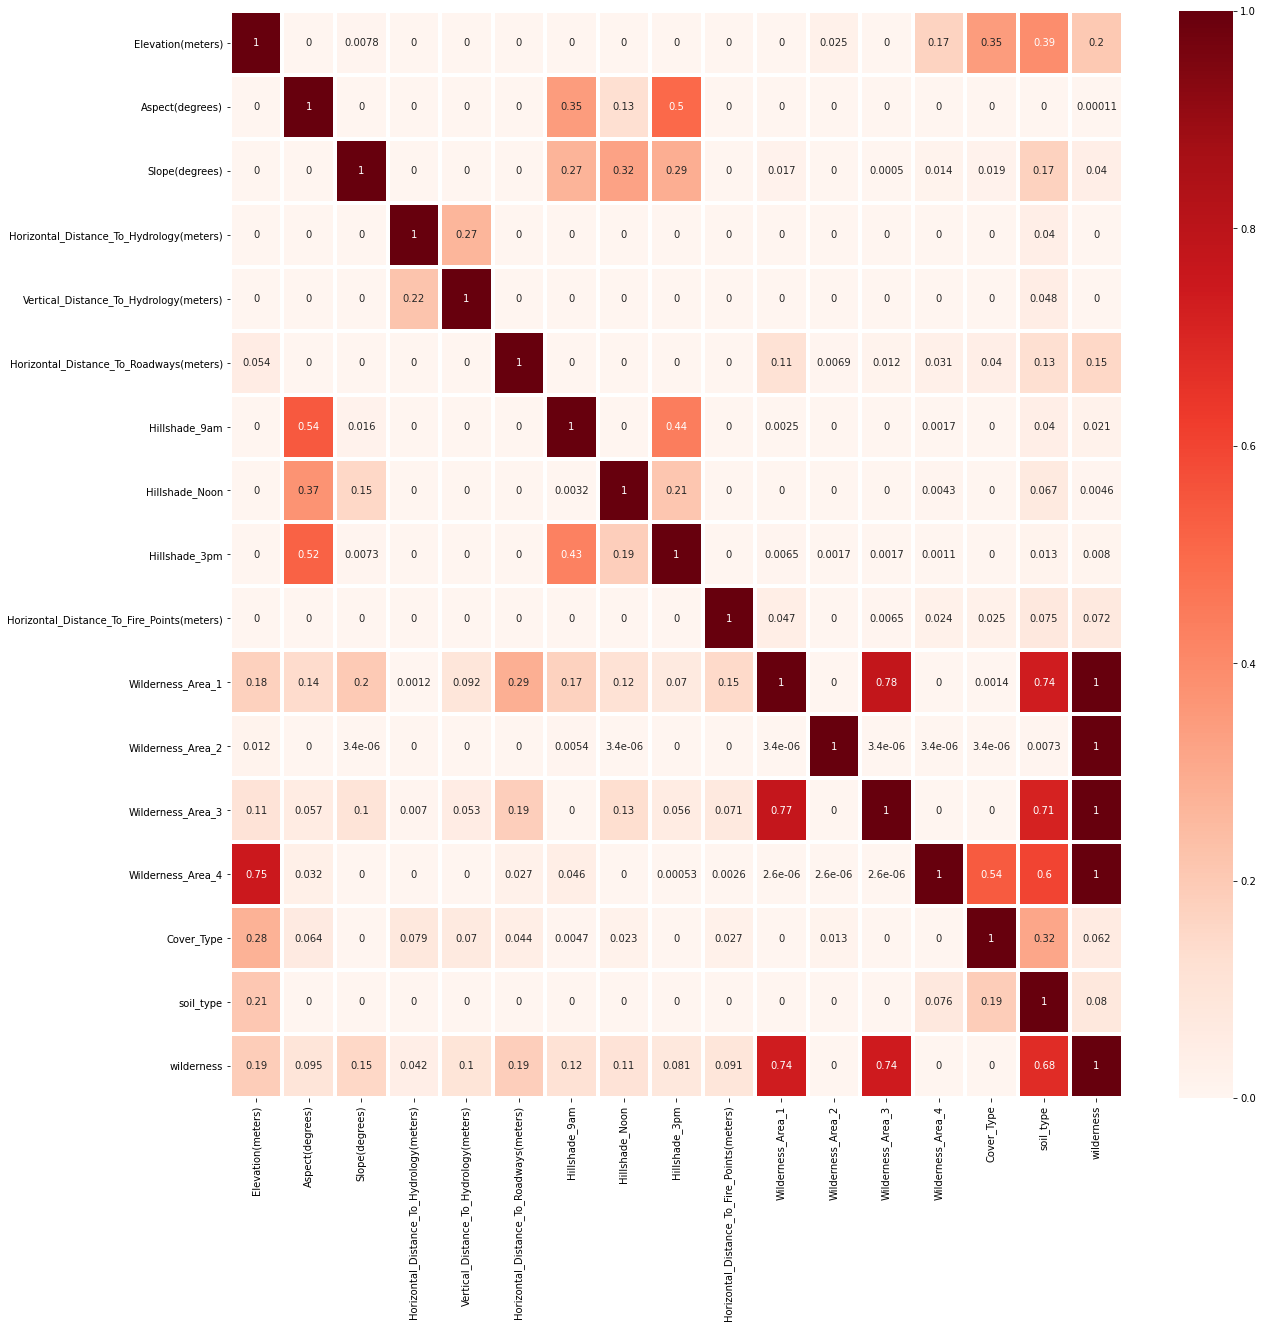

In [14]:
#Tree based relationships
df=pps.matrix(df_train.drop(['Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4',
       'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8',
       'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12',
       'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16',
       'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20',
       'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24',
       'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28',
       'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32',
       'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36',
       'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40'],axis=1))
fig, ax = plt.subplots(figsize=(20,20)) 
# sns.set(font_scale=1.3)
g=sns.heatmap(df, vmin=0, vmax=1, cmap="Reds", linewidths=3, annot=True,ax=ax,annot_kws={"fontsize":10})

#wilderness and soile can be thus used for catboost removing there one hot encoded transformations
#elevation seem to be a single important feature effecting target, thus we should develop some more features using it

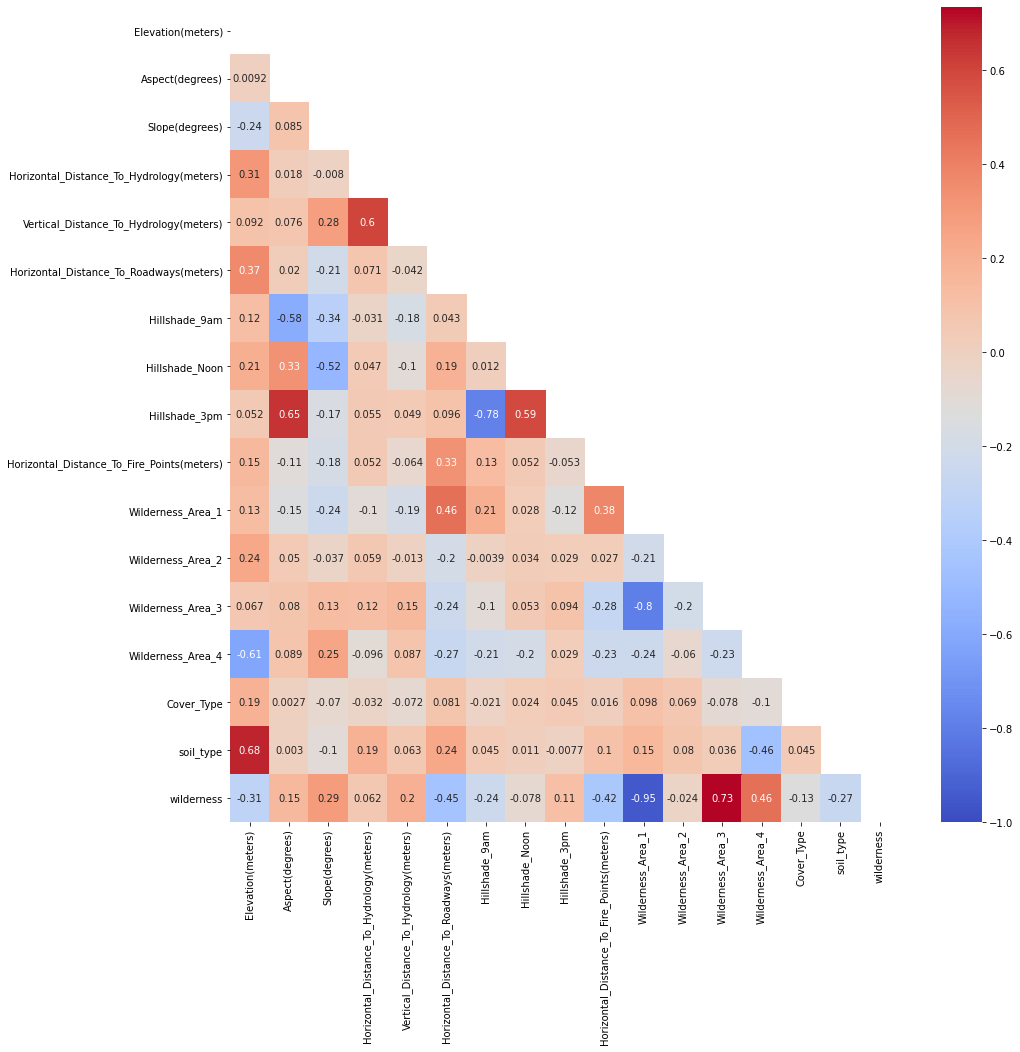

In [27]:
#identifying linear relationships and multicollinearity
df=df_train.drop(['Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4',
       'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8',
       'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12',
       'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16',
       'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20',
       'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24',
       'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28',
       'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32',
       'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36',
       'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40'],axis=1)
corr=df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(15,15))
sns.heatmap(corr,vmin=-1,cmap='coolwarm',annot=True,mask=mask);
#no strong linear relationships found with target

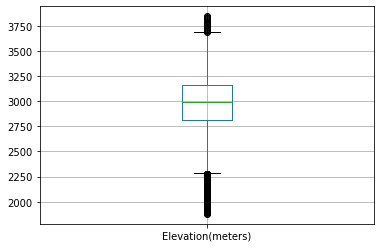

In [28]:
df_train.boxplot(column='Elevation(meters)')

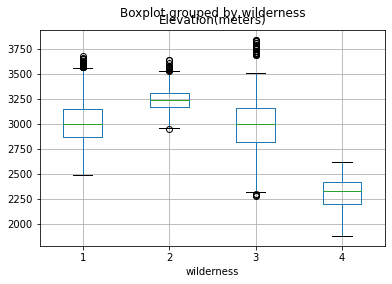

In [37]:
df_train.boxplot(column='Elevation(meters)',by='wilderness')

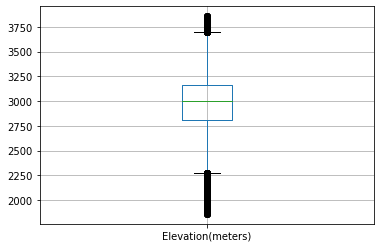

In [29]:
df_test.boxplot(column='Elevation(meters)')

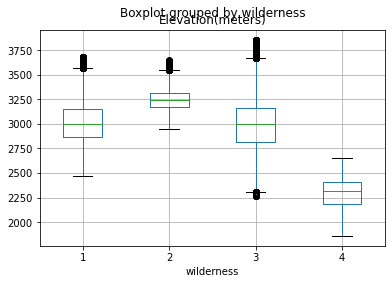

In [38]:
df_test.boxplot(column='Elevation(meters)',by='wilderness')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f657309d9b0>]],
      dtype=object)

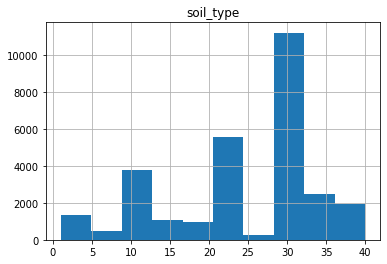

In [30]:
df_train.hist(column='soil_type')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6579856588>]],
      dtype=object)

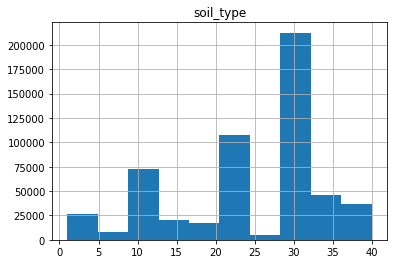

In [31]:
df_test.hist(column='soil_type')

In [32]:
#as train and test are a exact match the distribution of train and test should be assumed to be same too. thus no need for oversampling of minority classes
#the data must have been split in stratified manner to form train test
df_train.Cover_Type.value_counts()

5    14165
7    10592
6     1788
1     1025
3      868
2      475
4      137
Name: Cover_Type, dtype: int64

In [34]:
#the uncanny similarity between test and train even more prominent below
df_train.describe()

,Elevation(meters),Aspect(degrees),Slope(degrees),Horizontal_Distance_To_Hydrology(meters),Vertical_Distance_To_Hydrology(meters),Horizontal_Distance_To_Roadways(meters),Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points(meters),Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Wilderness_Area_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type,soil_type,wilderness
count,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.0,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000,29050.000000
mean,2959.328330,155.720241,14.028537,269.220792,46.332737,2346.340241,212.042134,223.446850,142.854630,1971.574871,0.450843,0.050327,0.435422,0.063408,0.004819,0.011945,0.007917,0.021480,0.002719,0.012771,0.000310,0.000516,0.001997,0.055077,0.020861,0.051566,0.030809,0.001170,0.0,0.004750,0.006231,0.003305,0.006850,0.017005,0.001274,0.057212,0.097074,0.036730,0.000585,0.004303,0.001824,0.001824,0.200172,0.051842,0.042065,0.091738,0.078967,0.002719,0.003064,0.000207,0.000379,0.027539,0.023821,0.014561,5.536110,24.391842,2.111394
std,277.578227,112.109417,7.458200,212.406921,58.938186,1558.148732,26.678889,19.610671,38.000582,1321.145310,0.497586,0.218623,0.495821,0.243699,0.069255,0.108640,0.088628,0.144981,0.052078,0.112287,0.017599,0.022718,0.044639,0.228135,0.142920,0.221153,0.172803,0.034192,0.0,0.068761,0.078689,0.057392,0.082484,0.129293,0.035666,0.232251,0.296064,0.188101,0.024184,0.065457,0.042675,0.042675,0.400136,0.221711,0.200742,0.288661,0.269692,0.052078,0.055267,0.014370,0.019456,0.163650,0.152494,0.119790,1.438261,9.467772,1.061851
min,1879.000000,0.000000,0.000000,0.000000,-166.000000,0.000000,58.000000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1103.000000,198.000000,213.000000,120.000000,1020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,20.000000,1.000000
50%,2995.000000,128.000000,13.000000,218.000000,29.000000,1984.000000,218.000000,226.000000,143.000000,1704.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [35]:
df_test.describe()

,Elevation(meters),Aspect(degrees),Slope(degrees),Horizontal_Distance_To_Hydrology(meters),Vertical_Distance_To_Hydrology(meters),Horizontal_Distance_To_Roadways(meters),Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points(meters),Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Wilderness_Area_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,soil_type,wilderness
count,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.00000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.00000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000,551962.000000
mean,2959.367246,155.653469,14.107660,269.439133,46.423388,2350.346942,212.151518,223.311973,142.511086,1980.749972,0.448761,0.051493,0.436108,0.063638,0.005238,0.013005,0.008321,0.021328,0.00275,0.011240,0.000174,0.000297,0.001973,0.056225,0.021386,0.051585,0.029959,0.001024,0.000005,0.004904,0.005872,0.003267,0.006924,0.01588,0.001451,0.057451,0.099521,0.036617,0.000828,0.004464,0.001872,0.001618,0.198260,0.051931,0.044286,0.090321,0.077650,0.002776,0.003265,0.000205,0.000520,0.026765,0.023759,0.015086,24.360896,2.114624
std,280.111066,111.903513,7.489805,212.557036,58.261247,1559.314218,26.774683,19.776974,38.288850,1324.355138,0.497368,0.221001,0.495901,0.244108,0.072182,0.113294,0.090841,0.144474,0.05237,0.105421,0.013187,0.017235,0.044374,0.230356,0.144666,0.221188,0.170473,0.031978,0.002331,0.069859,0.076402,0.057060,0.082924,0.12501,0.038067,0.232703,0.299361,0.187819,0.028762,0.066664,0.043220,0.040190,0.398689,0.221888,0.205729,0.286642,0.267621,0.052610,0.057044,0.014307,0.022797,0.161395,0.152297,0.121896,9.486339,1.061266
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1998.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [63]:


#feat engineering
#ENCODINGS


df=pd.DataFrame(df_train.groupby(['wilderness','soil_type'])['soil_type'].count()/df_train.groupby('wilderness')['wilderness'].count())
df=df.reset_index()
df.rename(columns={0:'fe'},inplace=True)
df['flora']=df[['wilderness','soil_type']].apply(lambda x: '_'.join(x.astype('str')), axis = 1)
encode = dict(zip(df.flora, df.fe))
df_train['flora']=df_train[['wilderness','soil_type']].apply(lambda x: '_'.join(x.astype('str')), axis = 1)
df_train['soil_fe']=df_train.flora.map(encode)
df_train['soil_fe']=df_train['soil_fe']*100
df_train.drop(['flora'],axis=1,inplace=True)


df=pd.DataFrame(df_test.groupby(['wilderness','soil_type'])['soil_type'].count()/df_test.groupby('wilderness')['wilderness'].count())
df=df.reset_index()
df.rename(columns={0:'fe'},inplace=True)
df['flora']=df[['wilderness','soil_type']].apply(lambda x: '_'.join(x.astype('str')), axis = 1)
encode = dict(zip(df.flora, df.fe))
df_test['flora']=df_test[['wilderness','soil_type']].apply(lambda x: '_'.join(x.astype('str')), axis = 1)
df_test['soil_fe']=df_test.flora.map(encode)
df_test['soil_fe']=df_test['soil_fe']*100
df_test.drop(['flora'],axis=1,inplace=True)



#NEW FEATS
df_train['hypotenuse']=np.sqrt(df_train['Horizontal_Distance_To_Hydrology(meters)']**2+df_train['Vertical_Distance_To_Hydrology(meters)']**2)
df_train['hill_9_sq']=df_train['Hillshade_9am']**2
df_train['hill_noon_sq']=df_train['Hillshade_Noon']**2
df_train['Elevation(meters)_hd_hdg']=df_train['Elevation(meters)']-0.2*df_train['Horizontal_Distance_To_Hydrology(meters)']
df_train['Elevation(meters)_hd_road']=df_train['Elevation(meters)']-0.5*df_train['Horizontal_Distance_To_Roadways(meters)']
df_train['Elevation(meters)_vd_hdg']=df_train['Elevation(meters)']-df_train['Vertical_Distance_To_Hydrology(meters)']
df_train['mean_amenities']=(df_train['Horizontal_Distance_To_Hydrology(meters)']+df_train['Horizontal_Distance_To_Roadways(meters)']+
df_train['Horizontal_Distance_To_Fire_Points(meters)'])/3
df_train['mean_amenities_fire_water']=(df_train['Horizontal_Distance_To_Hydrology(meters)']+df_train['Horizontal_Distance_To_Fire_Points(meters)'])/2


df_test['hypotenuse']=np.sqrt(df_test['Horizontal_Distance_To_Hydrology(meters)']**2+df_test['Vertical_Distance_To_Hydrology(meters)']**2)
df_test['hill_9_sq']=df_test['Hillshade_9am']**2
df_test['hill_noon_sq']=df_test['Hillshade_Noon']**2
df_test['Elevation(meters)_hd_hdg']=df_test['Elevation(meters)']-0.2*df_test['Horizontal_Distance_To_Hydrology(meters)']
df_test['Elevation(meters)_hd_road']=df_test['Elevation(meters)']-0.5*df_test['Horizontal_Distance_To_Roadways(meters)']
df_test['Elevation(meters)_vd_hdg']=df_test['Elevation(meters)']-df_test['Vertical_Distance_To_Hydrology(meters)']
df_test['mean_amenities']=(df_test['Horizontal_Distance_To_Hydrology(meters)']+df_test['Horizontal_Distance_To_Roadways(meters)']+
df_test['Horizontal_Distance_To_Fire_Points(meters)'])/3
df_test['mean_amenities_fire_water']=(df_test['Horizontal_Distance_To_Hydrology(meters)']+df_test['Horizontal_Distance_To_Fire_Points(meters)'])/2


soil_family={1:'cathedral',2:'vanet',3:'Haploborolis',4:'Ratake',5:'vanet',6:'vanet',7:'Gothic',8:'Supervisor',9:'Troutville',10:'Bullwark',11:'Bullwark',
12:'Legault',13:'Catamount',14:'Pachic',15:'Cryaquolis',16:'Cryaquolis',17:'Gateview',18:'Rogert',19:'Typic',20:'Typic',21:'Typic',
22:'Leighcan',23:'Leighcan',24:'Leighcan',25:'Leighcan',26:'Granile',27:'Leighcan',28:'Leighcan',29:'como',30:'como',31:'Leighcan',32:'Catamount',33:'Leighcan',
34:'Cryorthents',35:'Cryumbrepts',36:'Bross',37:'Rock',38:'Leighcan',39:'Moran',40:'Moran'}
df_train['soil_fam']=df_train.soil_type.map(soil_family)
df_test['soil_fam']=df_test.soil_type.map(soil_family)

df_log=df_train.drop(['soil_type','wilderness','soil_fam','Cover_Type'],axis=1)
df_log_test=df_test.drop(['soil_type','wilderness','soil_fam'],axis=1)
#scaling
scaled=df_log
scaled_test=df_log_test

#reverse clustering fitted on test prediction on train
min_max_scaler = preprocessing.MinMaxScaler()
df2_scaled = min_max_scaler.fit_transform(scaled)
bad_indices = np.where(np.isnan(df2_scaled))
df2_scaled[bad_indices] = 0

min_max_scaler = preprocessing.MinMaxScaler()
df2_scaled_test = min_max_scaler.fit_transform(scaled_test)
bad_indices = np.where(np.isnan(df2_scaled_test))
df2_scaled_test[bad_indices] = 0
# #kmeans
kmeans = KMeans(n_clusters=7, init='k-means++')
# fitting the k means algorithm on scaled data
kmeans.fit(df2_scaled_test)
pred=kmeans.predict(df2_scaled_test)
df_test['tree_cluster']=pred
pred2=kmeans.predict(df2_scaled)
df_train['tree_cluster']=pred2

#simple mode target encodings, once check with them score once without them score(preferably should be used with kfold strategy)
columns=['soil_type','soil_fam','wilderness']
df=pd.DataFrame(df_train.groupby(columns)['Cover_Type'].agg(pd.Series.mode))
df=df.reset_index()
df['te1']=df[columns].apply(lambda x: '_'.join(x.astype('str')), axis = 1)
encode = dict(zip(df.te1, df.Cover_Type))
df_train['te1']=df_train[columns].apply(lambda x: '_'.join(x.astype('str')), axis = 1)
df_test['te1']=df_test[columns].apply(lambda x: '_'.join(x.astype('str')), axis = 1)
df_train['target_encode4']=df_train.te1.map(encode)
df_test['target_encode4']=df_test.te1.map(encode)
df_test['target_encode4'].fillna(df_test['target_encode4'].mean(),inplace=True)
df_train.drop(['te1'],axis=1,inplace=True)

#tree models prefer label encodings over onehot generally
df_train=df_train.drop(['Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4',
       'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8',
       'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12',
       'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16',
       'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20',
       'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24',
       'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28',
       'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32',
       'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36',
       'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40'],axis=1)

#to be used for catboost
df_train['slope_fe_int']=df_train['soil_fe'].astype('int16')
df_train['hypotenuse_int']=df_train['hypotenuse'].astype('int16')
df_train['mean_amenities_int']=df_train['mean_amenities'].astype('int16')
df_train['mean_amenities_fire_water_int']=df_train['mean_amenities_fire_water'].astype('int16')
df_train['Elevation(meters)_hd_hdg_int']=df_train['Elevation(meters)_hd_hdg'].astype('int16')
df_train['Elevation(meters)_hd_road_int']=df_train['Elevation(meters)_hd_road'].astype('int16')
df_train['Elevation(meters)_hd_road_int']=df_train['Elevation(meters)_hd_road'].astype('int16')

df_test['slope_fe_int']=df_test['soil_fe'].astype('int16')
df_test['hypotenuse_int']=df_test['hypotenuse'].astype('int16')
df_test['mean_amenities_int']=df_test['mean_amenities'].astype('int16')
df_test['mean_amenities_fire_water_int']=df_test['mean_amenities_fire_water'].astype('int16')
df_test['Elevation(meters)_hd_hdg_int']=df_test['Elevation(meters)_hd_hdg'].astype('int16')
df_test['Elevation(meters)_hd_road_int']=df_test['Elevation(meters)_hd_road'].astype('int16')
df_test['Elevation(meters)_hd_road_int']=df_test['Elevation(meters)_hd_road'].astype('int16')

Y=df_train.Cover_Type

In [90]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29050 entries, 0 to 29049
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Elevation(meters)                           29050 non-null  int64  
 1   Aspect(degrees)                             29050 non-null  int64  
 2   Slope(degrees)                              29050 non-null  int64  
 3   Horizontal_Distance_To_Hydrology(meters)    29050 non-null  int64  
 4   Vertical_Distance_To_Hydrology(meters)      29050 non-null  int64  
 5   Horizontal_Distance_To_Roadways(meters)     29050 non-null  int64  
 6   Hillshade_9am                               29050 non-null  int64  
 7   Hillshade_Noon                              29050 non-null  int64  
 8   Hillshade_3pm                               29050 non-null  int64  
 9   Horizontal_Distance_To_Fire_Points(meters)  29050 non-null  int64  
 10  Wilderness

In [87]:
#main

#6000
catboost_model2 = CatBoostClassifier(cat_features=[14,15,16,17,18],task_type='GPU',verbose=0,iterations=6000,
bagging_temperature=0.41010395885331385,border_count=186,depth=8,
l2_leaf_reg=21,learning_rate=0.1673344419215237,random_strength=3.230824361824754e-06,one_hot_max_size=20)

#after deploying extensive feature selection process
cat_columns=['Horizontal_Distance_To_Hydrology(meters)',
       'Horizontal_Distance_To_Roadways(meters)', 'Hillshade_9am',
       'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points(meters)',
       'hill_9_sq', 'hill_noon_sq', 'Elevation(meters)_vd_hdg', 'slope_fe_int',
       'hypotenuse_int', 'mean_amenities_int', 'mean_amenities_fire_water_int',
       'Elevation(meters)_hd_hdg_int', 'Elevation(meters)_hd_road_int',
       'soil_type','wilderness','soil_fam','tree_cluster','target_encode4']

TRAIN_FINAL=df_train[cat_columns]
TEST_FINAL=df_test[cat_columns]





In [88]:
i=0
l=[]
fold = StratifiedKFold(n_splits=5,random_state=True)
scores=[]
i=1
cnf_matrix=[]
# kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in fold.split(TRAIN_FINAL,Y):
    x_train, x_test = TRAIN_FINAL.values[train], TRAIN_FINAL.values[test]
    y_train, y_test = Y.values[train], Y.values[test] 
    model = catboost_model2
    # eval_dataset = Pool(data=X_val,
    #                 label=Y_val,
    #                 cat_features=[17,18,19])
    model.fit(x_train, y_train)
    preds = model.predict_proba(x_test)

    # for classification only
    # preds2 = model.predict(x_train)
    # cnf_matrix.append(confusion_matrix(y_test, preds2,labels=[1,2,3,4,5,6,7]))
    # ######################
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = TRAIN_FINAL.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum)
    score = log_loss(y_test, preds)
    scores.append(score)
    print(score)
    i+=1
print("Average: ", np.sum(scores)/len(scores))
##for classification only
cm=0
for item in cnf_matrix:
  try:
    cm=cm+item
  except:
    cm=item



0.23905594509883574
0.23701235799933873
0.24129861454725665
0.23615249557035403
0.23819590569546958
Average:  0.23834306378225095


In [79]:
import re
train_set=TRAIN_FINAL
labels=Y
add=0
for item in l:
  add+=item
df_cv=pd.DataFrame(add/len(l),index=train_set.columns,columns=["importance"]).sort_values('importance', ascending=False)
df_cv=df_cv.reset_index()
feat_imp = pd.Series(df_cv.importance.values, index=df_cv.drop(["importance"], axis=1)).sort_values(axis='index',ascending=False)
# 
feat_imp2=feat_imp[feat_imp>0.005]
imp_columns=[]
for item in pd.DataFrame(feat_imp2).reset_index()["index"].tolist():
  f=re.sub("[,]","",str(item))
  try:  
    columns= int(re.sub("['']","",f))
    imp_columns.append(columns)
  except:
    columns= re.sub("['']","",f)
  imp_columns.append(columns)
# X_train_tree4=df_train_cat2[imp_columns]
len(imp_columns)

19

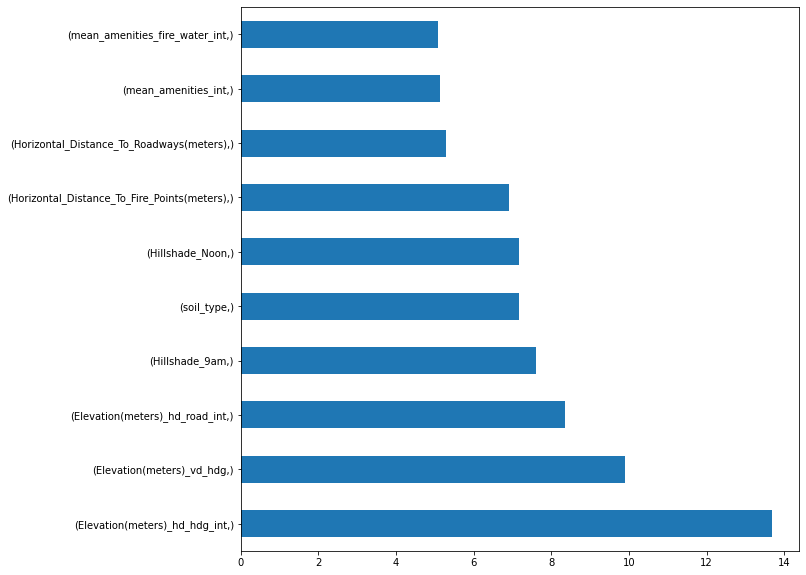

In [80]:
feat_imp.nlargest(10).plot(kind='barh', figsize=(10,10))
#as can be seen the engineered features are contributing heavily towards the overall model performance

In [ ]:
#submission module
model=catboost_model2
model.fit(TRAIN_FINAL.values,Y.values)
pred=model.predict_proba(TEST_FINAL.values)
pred_df=pd.DataFrame(pred)
pred_df.rename(columns={0:1,1:2,2:3,3:4,4:5,5:6,6:7},inplace=True)
pred_df['wilderness']=TEST_FINAL['wilderness']
pred_df.rename(columns={1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven'},inplace=True)

#the presence of wilderness and soil w.r.t to target in train 

# #tree wilderness map
# wilderness 1=1,2,5,7
# wilderness 2=1,5,7
# wilderness 3= 1,2,3,5,6,7
# wilderness 4=3,4,5,6

#soil fam map
#bross,#cryumbepts,#moran 1,5,7
#cathedral,#pachic 3,4,6
#como,#cryorthents 1,2,5,7
#gothic 5
#granile,#rogert 2,5,7
#haploborolis 3,4,5
#legault,#supervisor,#troutville 5,7
#leighcan,#typic,#catamount 1,2,3,5,6,7
#rock 1
#vanet 2,3,4,5,6
#bullwark,cryaquolis,#gateview 2,3,4,5,6,7

#leveraging the similarity between test and train we can build a hypothesis that the cover types not present in the above combinations in train
#will also not be present in similar combinations in test
#as logloss punishes confidently wrong far more than it rewards confidently right, its imperative we try to decrease the first type of errors as below

pred_df.loc[pred_df.wilderness == 4, ['seven', 'one','two']] = 0,0,0
pred_df.loc[pred_df.wilderness == 3, ['four']] = 0
pred_df.loc[pred_df.wilderness == 2, ['two','three','four','six']] = 0,0,0,0
pred_df.loc[pred_df.wilderness == 1, ['three','four','six']] = 0,0,0
pred_df.rename(columns={'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7},inplace=True)
pred_df.drop(['wilderness'],axis=1,inplace=True)
pred_df['soil_fam']=Test['soil_fam']
pred_df.rename(columns={1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven'},inplace=True)
pred_df.loc[pred_df.soil_fam == 'Bross', ['two', 'three','four','six']] = 0,0,0,0
pred_df.loc[pred_df.soil_fam == 'Cryumbrepts', ['two', 'three','four','six']] = 0,0,0,0
pred_df.loc[pred_df.soil_fam == 'Moran', ['two', 'three','four','six']] = 0,0,0,0
pred_df.loc[pred_df.soil_fam == 'cathedral', ['one', 'two','five','seven']] = 0,0,0,0
pred_df.loc[pred_df.soil_fam == 'Pachic', ['one', 'two','five','seven']] = 0,0,0,0
pred_df.loc[pred_df.soil_fam == 'como', ['four','six']] = 0,0
pred_df.loc[pred_df.soil_fam == 'Cryorthents', ['four','six']] = 0,0
pred_df.loc[pred_df.soil_fam == 'Rogert', ['one','three', 'four','six']] = 0,0,0,0
pred_df.loc[pred_df.soil_fam == 'Granile', ['one','three', 'four','six']] = 0,0,0,0
pred_df.loc[pred_df.soil_fam == 'Haploborolis', ['one','two', 'seven']] = 0,0,0
pred_df.loc[pred_df.soil_fam == 'Legault', ['one','two','three', 'four','six']] = 0,0,0,0,0
pred_df.loc[pred_df.soil_fam == 'Supervisor', ['one','two','three', 'four','six']] = 0,0,0,0,0
pred_df.loc[pred_df.soil_fam == 'Troutville', ['one','two','three', 'four','six']] = 0,0,0,0,0
pred_df.loc[pred_df.soil_fam == 'Rock', ['two','three', 'four','five','six','seven']] = 0,0,0,0,0,0
pred_df.loc[pred_df.soil_fam == 'vanet', ['one','seven']] = 0,0
pred_df.loc[pred_df.soil_fam == 'Cryaquolis', ['one']] = 0
pred_df.loc[pred_df.soil_fam == 'Bullwark', ['one']] = 0
pred_df.loc[pred_df.soil_fam == 'Gateview', ['one']] = 0
pred_df.loc[pred_df.soil_fam == 'Typic', ['four']] = 0
pred_df.loc[pred_df.soil_fam == 'Leighcan', ['four']] = 0
pred_df.loc[pred_df.soil_fam == 'Catamount', ['four']] = 0
pred_df.loc[pred_df.soil_fam == 'Gothic', ['one','two','three', 'four','six','seven']] = 0,0,0,0,0,0
pred_df.drop(['soil_fam'],axis=1,inplace=True)
pred_df.rename(columns={'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7},inplace=True)

pred_df=reduce_mem_usage(pred_df)

pred_df.to_csv("/GD/My Drive/forest/sol1.csv",index=False)




